In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#!pip install pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split


import warnings
warnings.filterwarnings("ignore")
sns.set_style()

In [3]:
dados = pd.read_csv(r'D:\Blue EdTech\Bootcamp\dados\full_grouped.csv')
df = dados[dados['Country/Region'].isin(['Mexico', 'Argentina', 
                                        'Ecuador', 'Chile', 'Spain'])]

df['Date'] = pd.to_datetime(df.Date, format="%Y-%m-%d")

In [4]:
df

,Date,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,WHO Region
6,2020-01-22,Argentina,0,0,0,0,0,0,0,Americas
35,2020-01-22,Chile,0,0,0,0,0,0,0,Americas
51,2020-01-22,Ecuador,0,0,0,0,0,0,0,Americas
111,2020-01-22,Mexico,0,0,0,0,0,0,0,Americas
157,2020-01-22,Spain,0,0,0,0,0,0,0,Europe
...,...,...,...,...,...,...,...,...,...,...
34975,2020-07-27,Argentina,167416,3059,72575,91782,4890,120,2057,Americas
35004,2020-07-27,Chile,347923,9187,319954,18782,2133,75,1859,Americas
35020,2020-07-27,Ecuador,81161,5532,34896,40733,467,17,0,Americas
35080,2020-07-27,Mexico,395489,44022,303810,47657,4973,342,8588,Americas


## Estacionariedade e Dickey Fuller

### Funções

#### criar_serie
* com confirmados e obitos
* a coluna de data como index

In [5]:
def criar_serie(df, nome_pais):

    filtro = df[df['Country/Region'] == nome_pais]
    pais = filtro[['Date', 'Confirmed', 'Deaths']]
    
    pd.to_datetime(pais.Date)
    pais.set_index('Date', inplace=True)
    
    return pais


argentina = criar_serie(df, 'Argentina')
chile = criar_serie(df, 'Chile')
equador = criar_serie(df, 'Ecuador')
mexico = criar_serie(df, 'Mexico')
espanha = criar_serie(df, 'Spain')

full_serie = criar_serie(df, df['Country/Region'])

#### media_movel

In [6]:
def media_movel(serie, periodo):
    
    fig, axs = plt.subplots(2, 1, figsize=(15, 5), constrained_layout=True)

    # Valores originais
    ax = axs[0]
    mm = serie.Confirmed.resample(periodo).mean() # O periodo da media movel pode ser um numero inteiro seguido de D, W, M, Y ou apenas as iniciais
    ax.set_title(r'Valor original e média movel de Confirmados')
    ax.plot(serie.Confirmed, color='blue', label='Original')
    ax.plot(mm, color='red', label='Média movel')
    ax.legend(loc='best')

    # Media movel
    ax = axs[1]
    mm = serie.Deaths.resample(periodo).mean()
    ax.set_title(r'Valor original e média movel de Obitos')
    ax.plot(serie.Deaths, color='blue', label='Original')
    ax.plot(mm, color='red', label='Média movel')
    ax.legend(loc='best')


    return plt.show

### Analise de tendencia

O '.resample(periodo).mean()' na função media_movel irá retornar a media movel, fazendo com que seja possivel observar o grafico da serie sem os ruidos, facilitando a analise de tendencia dos dados.

Para entender melhor como funciona a media movel, suposmos que será utilizado o periodo de 15 dias para o salto da janela de observação, os primeiro 14 dias serão pulados, e apenas o dia 15 será observado, apartir desse dia, a media do dia posterior será calculada baseada na media dos 15 dias anteriores e o processo será repetido até o fim da serie.

<function matplotlib.pyplot.show(close=None, block=None)>

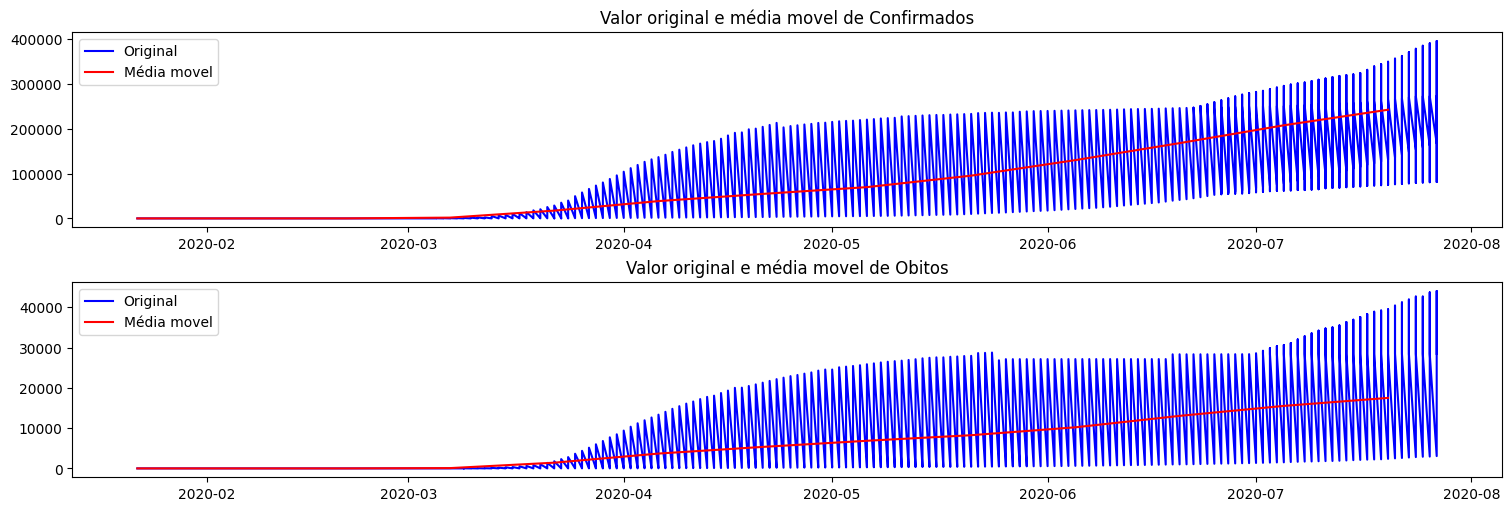

In [7]:
media_movel(full_serie, periodo='15D')

### Analise de sazionalidade

diff() ou diferença sucessiva, defini quantas diferenças será utilizado, por padrão o periodo é 1. (pesquisar sobre diferença sucessiva)

<AxesSubplot: xlabel='Date'>

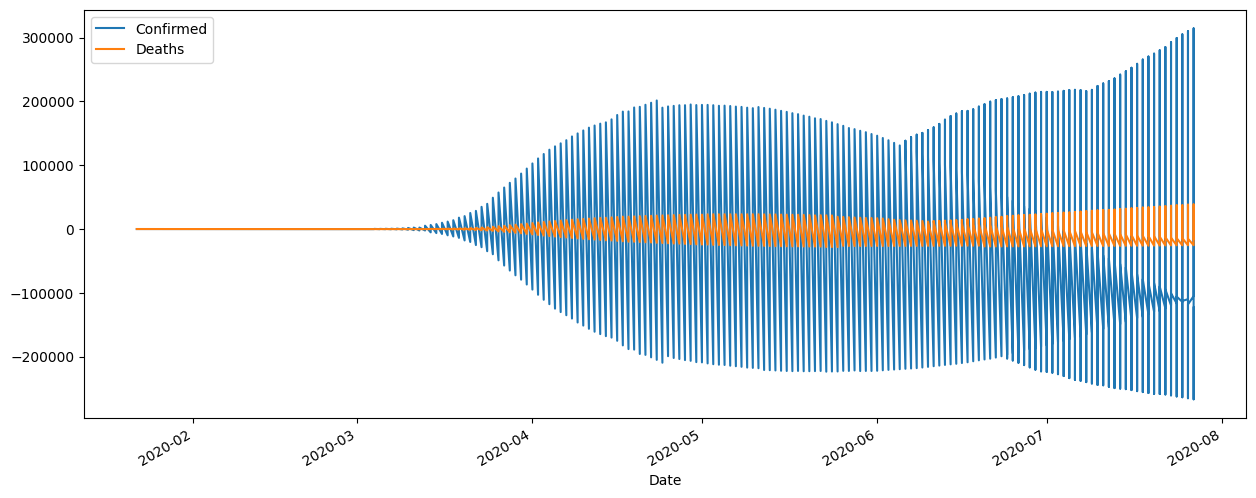

In [8]:
full_serie.diff().plot(figsize=(15,6)) 

<AxesSubplot: xlabel='Date'>

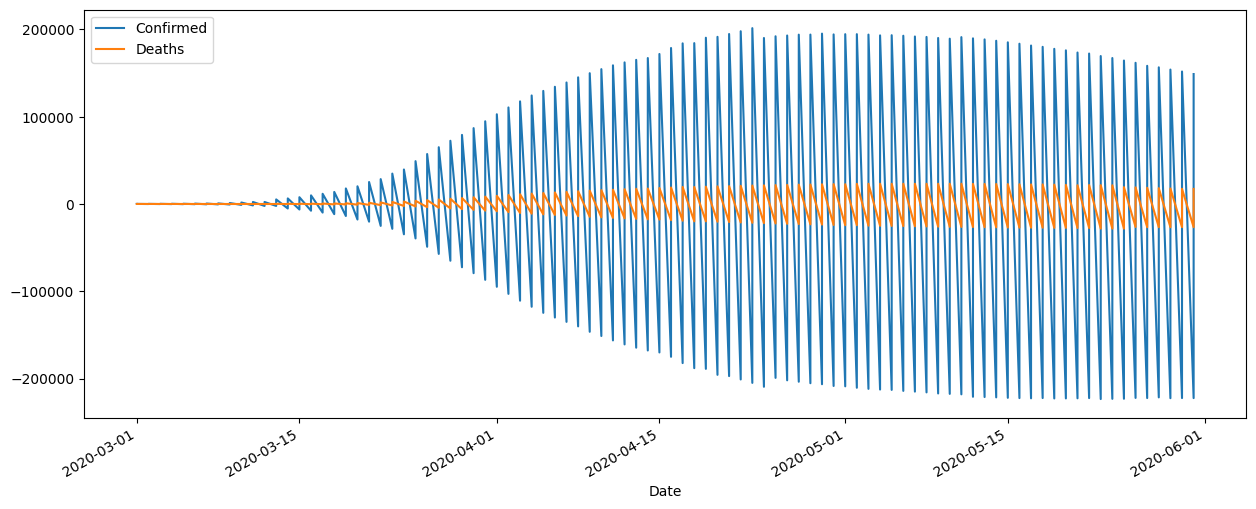

In [9]:
# criando filtros para analiser melhor o grafico
filtro = (full_serie.index.month >= 3) & (full_serie.index.month <=5)
full_serie[filtro].diff().plot(figsize=(15,6))

### Analisando ADF e Testando modelo SARIMAX

ADF Statistic: 1.0198679084570061
p-value: 0.9944712170177812
                                       SARIMAX Results                                        
Dep. Variable:                              Confirmed   No. Observations:                  188
Model:             SARIMAX(6, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -1643.025
Date:                                Mon, 16 Jan 2023   AIC                           3310.050
Time:                                        20:05:55   BIC                           3348.824
Sample:                                    01-22-2020   HQIC                          3325.761
                                         - 07-27-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.597

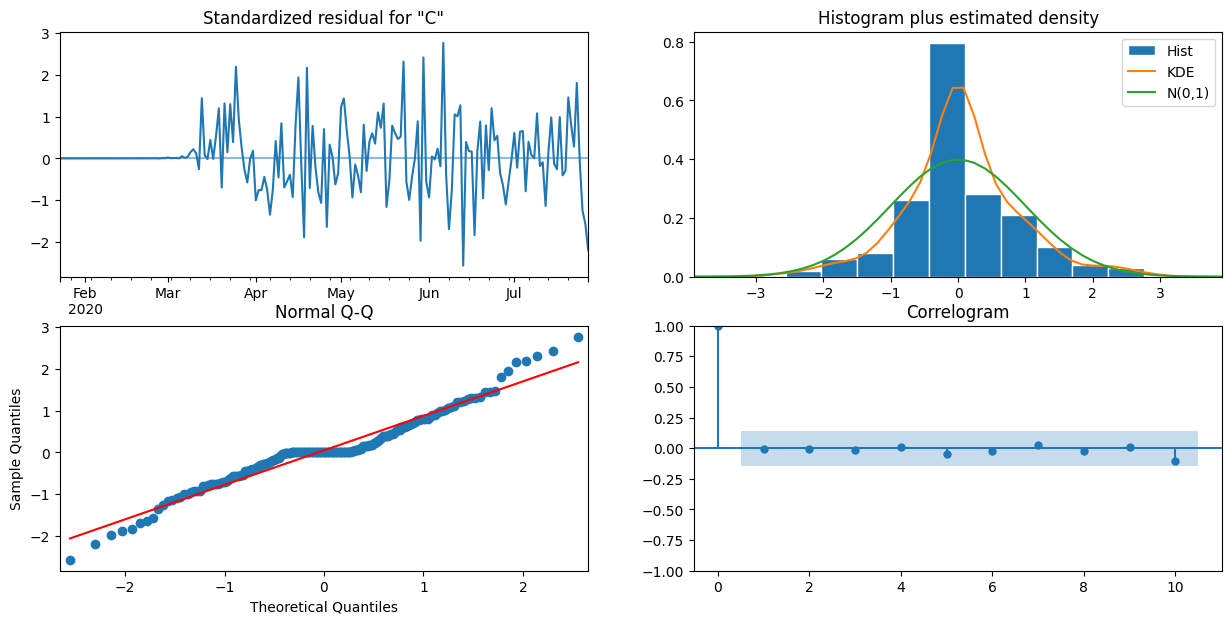

In [10]:
X = full_serie.groupby('Date').Confirmed.sum().copy()

# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(X)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')


# SARIMA Model
best_model = SARIMAX(X,order=(6,1,1),seasonal_order=(2,0,[1,2],7)).fit(dis=1)
print(best_model.summary()) # .tables[1]
best_model.plot_diagnostics(figsize=(15,7))
plt.show()

## SARIMAX (ajustado)

### Class Modelo_SARIMAX

In [11]:
class Modelo_SARIMAX():
    def __init__(self, serie, coluna):
        self.serie = serie
        self.coluna = coluna


    def autoarima_e_treino(self):
        
        # auto_arima
        X = self.serie.groupby('Date')[self.coluna].sum().copy()
        
        auto_arima(X,seasonal=True,m=7)
        stepwise_fit = auto_arima(X, start_p=0, start_q=0, 
                                    max_p=6, max_q=3, m=7,
                                    seasonal=True,
                                    trace=False, # True caso queira observar os valores de cada fit
                                    error_action='ignore',
                                    suppress_warnings=True,
                                    stepwise=True)
        results = [ stepwise_fit.get_params()['order'], 
                    stepwise_fit.get_params()['seasonal_order']]

        # Treinamento
        cut = int(X.shape[0] * 0.80)
        self.train = X.iloc[:cut]
        self.test = X.iloc[cut:]

        start = self.train.shape[0]
        end   = X.shape[0] - 1

        model = SARIMAX(self.train, 
                        order=results[0],
                        seasonal_order=results[1]).fit(dis=1)

        self.pred = model.predict(  start=start,
                                    end=end,
                                    dynamic=False,
                                    typ='levels')
        
        self.pred.index = self.test.index


    def metricas(self):
        print(f"R²   ---  {r2_score(self.test, self.pred):.2f}")
        print(f"MAE  ---  {mean_absolute_error(self.test, self.pred):.2f}")
        print(f"RMSE ---  {mean_squared_error(self.test, self.pred, squared=False):.2f}")
        print(f"MAPE ---  {mean_absolute_percentage_error(self.test, self.pred)}")


    def graficos(self):
        fig, axs = plt.subplots(2, 1, figsize=(14, 4), constrained_layout=True)

        ax = axs[0]
        ax.set_title(f'Predição para o Nº de {self.coluna[0]}')
        ax.plot(self.test, label='Test') # color='orange'
        ax.plot(self.pred, label='Prediction') # color='green'
        ax.legend(loc='best')

        ax = axs[1]
        ax.set_title(f'Predição para o Nº de {self.coluna[0]}')
        ax.plot(self.train, label='Train')
        ax.plot(self.test, label='Test')
        ax.plot(self.pred, label='Prediction')
        ax.legend(loc='best')

        plt.show()

### Analisando predição de confirmados

In [12]:
pred_confirmed_1 = Modelo_SARIMAX(  serie = full_serie,
                                    coluna = ['Confirmed'])

pred_confirmed_1.autoarima_e_treino()
pred_confirmed_1.metricas()


R²   ---  0.98
MAE  ---  16763.64
RMSE ---  23619.03
MAPE ---  0.014941680144294204


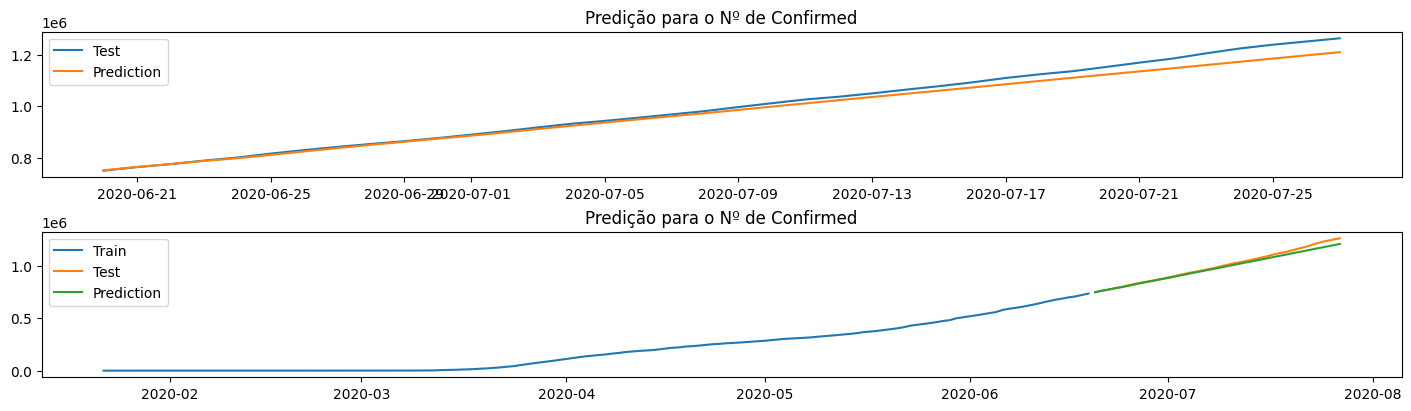

In [13]:
pred_confirmed_1.graficos()

É possivel notar mais uma melhora consideral nos resultados da analise das predições do numero de confirmados, saindo de um R² 0.92 para R² 0.98, além de um MAPE também menor.

### Analisando predição dos obitos

In [14]:
pred_deaths_1 = Modelo_SARIMAX(  serie = full_serie,
                                    coluna = ['Deaths'])

pred_deaths_1.autoarima_e_treino()
pred_deaths_1.metricas()

R²   ---  -0.91
MAE  ---  10949.68
RMSE ---  12778.26
MAPE ---  0.1375723009833041


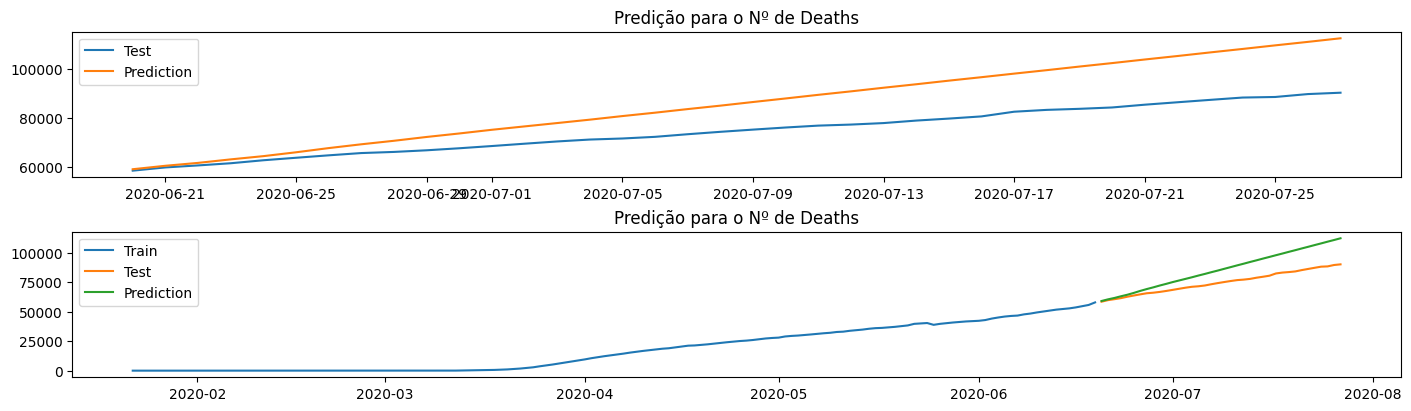

In [15]:
pred_deaths_1.graficos()

O resultado negativo do R² (-0.91) indica que as variaveis estão correlacionadas negativamente, e por está muito proximo de -1,0 essa associação pode ser considerada uma associação negativamente forte.

Podemos interpretar esse resultado da seguintemente maneira: o modelo preditivo está indicando que ao passar do tempo o numero de mortes tende a aumentar.

### Sobre as metricas

Erro Médio Absoluto (MAE), que é a média dos erros absolutos (ignorando o sinal positivo ou negativo). Assim sabemos melhor quanto estamos desviando dos valores reais nas unidades originais.

Erro Percentual Absoluto Médio (MAPE). É uma métrica bastante utilizada na área de previsões de séries temporais, e se refere à média do percentual de erros cometidos nas previsões, desconsiderando a direção (acima ou abaixo do real).

## Analisando países individualmente

### Argentina

In [16]:
pred_arg_confirmed = Modelo_SARIMAX(  serie = argentina,
                                    coluna = ['Confirmed'])

pred_arg_confirmed.autoarima_e_treino()
pred_arg_confirmed.metricas()

R²   ---  0.73
MAE  ---  13441.84
RMSE ---  19225.41
MAPE ---  0.11000709810415377


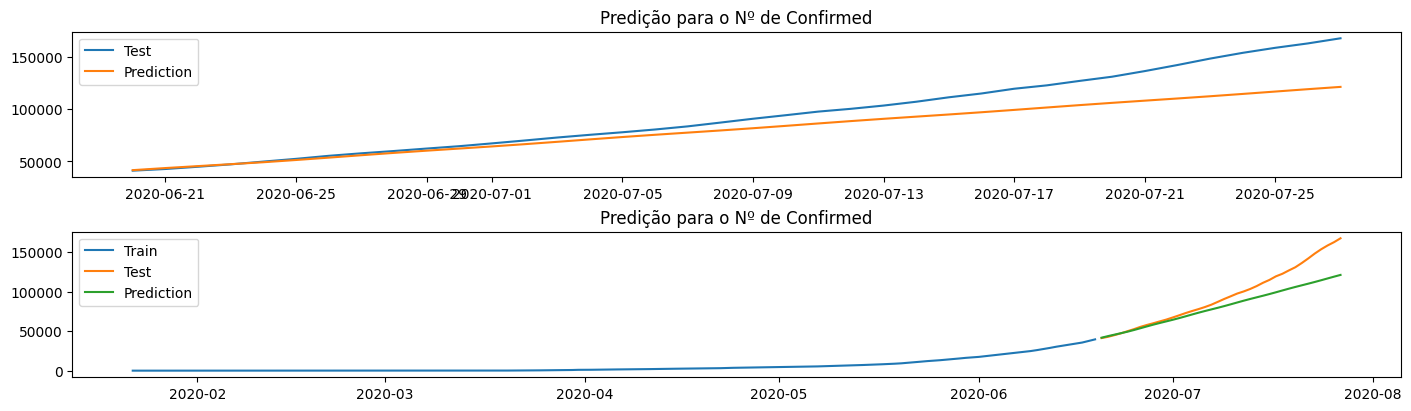

In [17]:
pred_arg_confirmed.graficos()

In [18]:
import csv

In [19]:
# pred_arg = pred_arg_confirmed.test.copy()
# pred_arg['pred'] = pred_arg_confirmed.pred.copy()
# pred_arg.to_csv('pred_arg.csv')

Usar argentina

### Chile

In [20]:
pred_chi_confirmed = Modelo_SARIMAX(  serie = chile,
                                    coluna = ['Confirmed'])

pred_chi_confirmed.autoarima_e_treino()
pred_chi_confirmed.metricas()

R²   ---  0.33
MAE  ---  23185.87
RMSE ---  26318.51
MAPE ---  0.07340878153168193


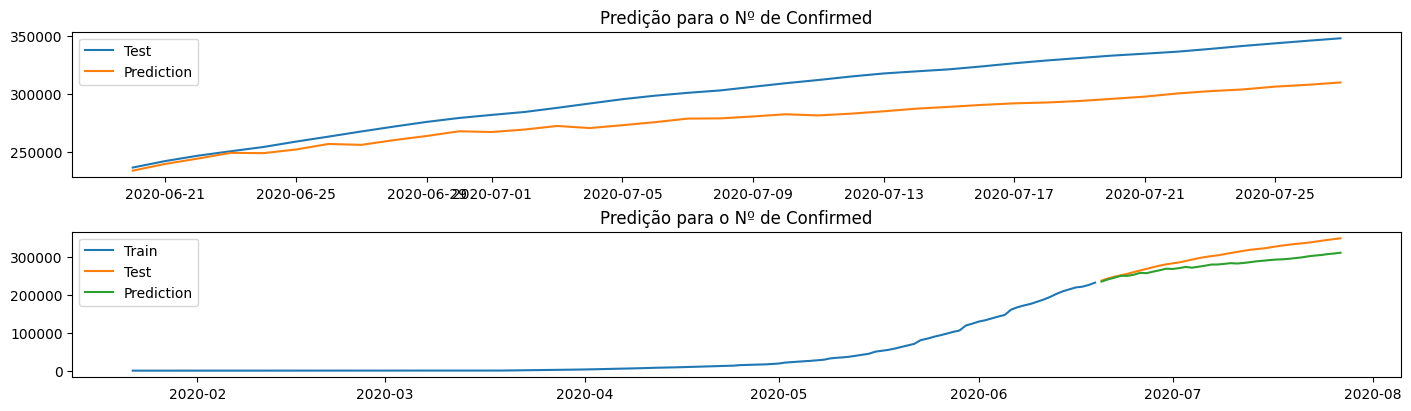

In [21]:
pred_chi_confirmed.graficos()

### Equador

In [22]:
pred_equa_confirmed = Modelo_SARIMAX(  serie = equador,
                                    coluna = ['Confirmed'])

pred_equa_confirmed.autoarima_e_treino()
pred_equa_confirmed.metricas()

R²   ---  0.61
MAE  ---  4811.19
RMSE ---  6043.72
MAPE ---  0.06743232709198481


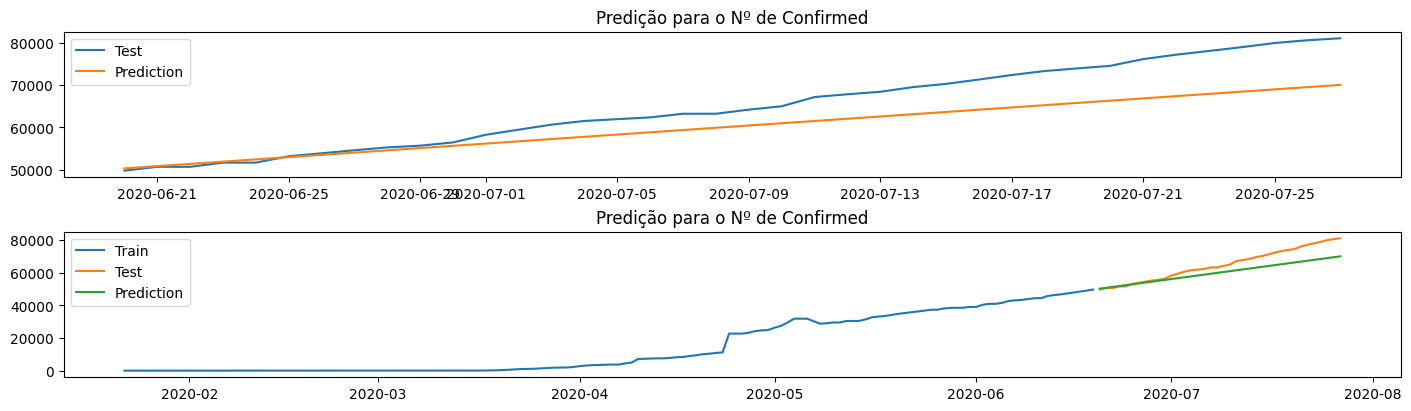

In [23]:
pred_equa_confirmed.graficos()

### Mexico

In [24]:
pred_mex_confirmed = Modelo_SARIMAX(  serie = mexico,
                                    coluna = ['Confirmed'])

pred_mex_confirmed.autoarima_e_treino()
pred_mex_confirmed.metricas()

R²   ---  0.99
MAE  ---  6410.04
RMSE ---  7491.77
MAPE ---  0.020848506097742536


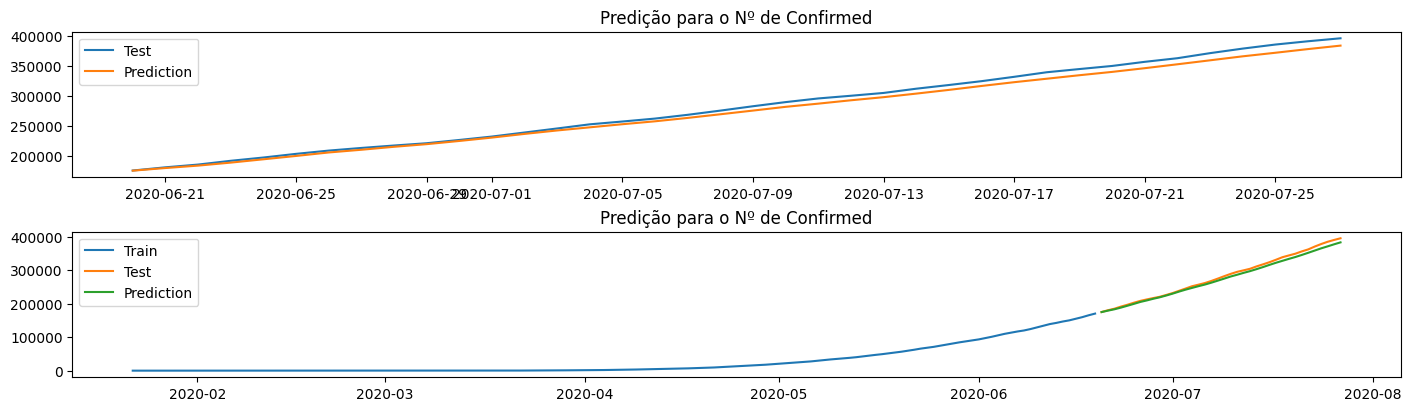

In [25]:
pred_mex_confirmed.graficos()

Usar mexico

In [26]:
# pred_mex = pred_mex_confirmed.test.copy()
# pred_mex['pred'] = pred_mex_confirmed.pred.copy()
# pred_mex.to_csv('pred_mex.csv')

### Espanha

In [27]:
pred_esp_confirmed = Modelo_SARIMAX(  serie = espanha,
                                    coluna = ['Confirmed'])

pred_esp_confirmed.autoarima_e_treino()
pred_esp_confirmed.metricas()

R²   ---  0.62
MAE  ---  2985.32
RMSE ---  5187.76
MAPE ---  0.011192836481776984


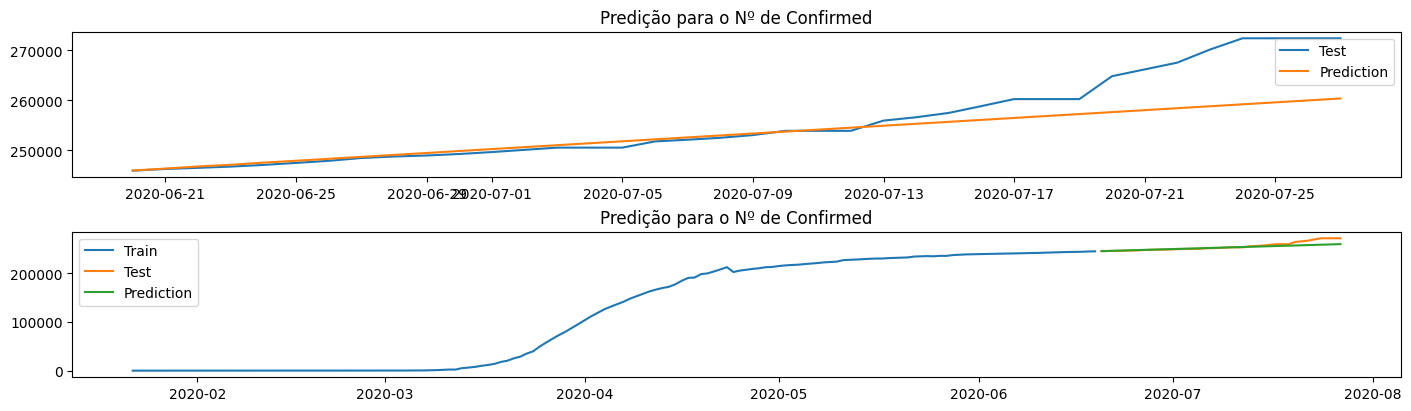

In [28]:
pred_esp_confirmed.graficos()

Essa subida repentida pode representar o inicio da segunda onda

In [29]:
pred_esp = pred_esp_confirmed.test.copy()
pred_esp['pred'] = pred_esp_confirmed.pred.copy()
pred_esp.to_csv('pred_esp.csv')

## Predição com analise de sentimento

### Classe

In [71]:
class SARIMAXModel_sentiment():
    def __init__(self, serie, coluna):
        self.serie = serie
        self.coluna = coluna


    def fit_and_predict(self):
        
        # auto_arima
        #X = self.serie.groupby('date')[self.coluna].sum().copy()
        X = self.serie
        
        auto_arima(X,seasonal=True,m=7)
        stepwise_fit = auto_arima(X, start_p=0, start_q=0, 
                                    max_p=6, max_q=3, m=7,
                                    seasonal=True,
                                    trace=False, # True caso queira observar os valores de cada fit
                                    error_action='ignore',
                                    suppress_warnings=True,
                                    stepwise=True)
        results = [ stepwise_fit.get_params()['order'], 
                    stepwise_fit.get_params()['seasonal_order']]

        # Treinamento
        cut = int(X.shape[0] * 0.80)
        self.train = X.iloc[:cut]
        self.test = X.iloc[cut:]

        start = self.train.shape[0]
        end   = X.shape[0] - 1

        model = SARIMAX(self.train, 
                        order=results[0],
                        seasonal_order=results[1]).fit(dis=1)

        self.pred = model.predict(  start=start,
                                    end=end,
                                    dynamic=False,
                                    typ='levels')
        
        self.pred.index = self.test.index


    def evaluate(self):
        print(f"R²   ---  {r2_score(self.test, self.pred):.2f}")
        print(f"MAE  ---  {mean_absolute_error(self.test, self.pred):.2f}")
        print(f"RMSE ---  {mean_squared_error(self.test, self.pred, squared=False):.2f}")
        print(f"MAPE ---  {mean_absolute_percentage_error(self.test, self.pred)}")


    def plot(self):
        fig, axs = plt.subplots(2, 1, figsize=(15, 6), constrained_layout=True)

        ax = axs[0]
        ax.set_title(f'Predição para o Nº de {self.coluna[0]}')
        ax.plot(self.test, label='Test') # color='orange'
        ax.plot(self.pred, label='Prediction') # color='green'
        ax.legend(loc='best')

        ax = axs[1]
        ax.set_title(f'Predição para o Nº de {self.coluna[0]}')
        ax.plot(self.train, label='Train')
        ax.plot(self.test, label='Test')
        ax.plot(self.pred, label='Prediction')
        ax.legend(loc='best')

        plt.show()

### Criando series

In [ ]:
df_sentimento = pd.read_csv(r'D:\Blue EdTech\Bootcamp\notebooks\bootcamp_covid-1\notebooks\data\df_analise.csv')

In [80]:
def create_sentiment_series(df, country, sentiment):

    country_filter = df[df['país'] == country]
    sentiment_filter = country_filter[country_filter['prediction'] == sentiment]
    country_data = sentiment_filter.groupby('date')[['prediction']].count()    

    
    country_data['date'] = pd.to_datetime(country_data.index)
    country_data.set_index('date', inplace=True)
    
    return country_data

### Função para escolher a predição

In [98]:
def create_sentiment_forecast(df):
    countries = ['argentina', 'chile', 'equador', 'espanha', 'mexico']
    running = True
    while running:
        print("""
    Deseja criar a previsão de sentimentos negativos para qual pais?

    Argentina  : 0
    Chile      : 1
    Ecuador    : 2
    Espanha    : 3
    Mexico     : 4
    """)

        choice = int(input('Digite um número: '))
        country = countries[choice]

        series = create_sentiment_series(df, country, 0).rolling(7).mean().dropna()
        print('Previsão em andamento...')
        forecast = SARIMAXModel_sentiment(serie = series,
                                          coluna = series.values)
        forecast.fit_and_predict()
        print(f'Previsão para "{country}" realizada com sucesso!\n')
        
        forecast.evaluate()
        forecast.plot()

        # forecast_csv = forecast.test.copy()
        # forecast_csv['prediction'] = forecast.predictions.copy()
        # forecast_csv.to_csv(r"{}\data\results_model_forecast\{}.csv".format(path, country))
        # print(f"Arquivo '{country}.csv' foi gerado!")
        # print(f"Ele pode ser encontrado em 'data/results_model_forecast/'")

        print('\nGostaria de realizar novas previsões?\nNão : 0\nSim : 1')
        continue_choice = int(input('Digite um número: '))
        if continue_choice == 0:
            running = False
            print('\nPROGRAMA FINALIZADO!\n')

## Metricas previsão de sentimento negativo por país

### Argentina


    Deseja criar a previsão de sentimentos negativos para qual pais?

    Argentina  : 0
    Chile      : 1
    Ecuador    : 2
    Espanha    : 3
    Mexico     : 4
    
Previsão em andamento...
Previsão para "argentina" realizada com sucesso!

R²   ---  0.03
MAE  ---  2.84
RMSE ---  3.37
MAPE ---  0.07562028340532272


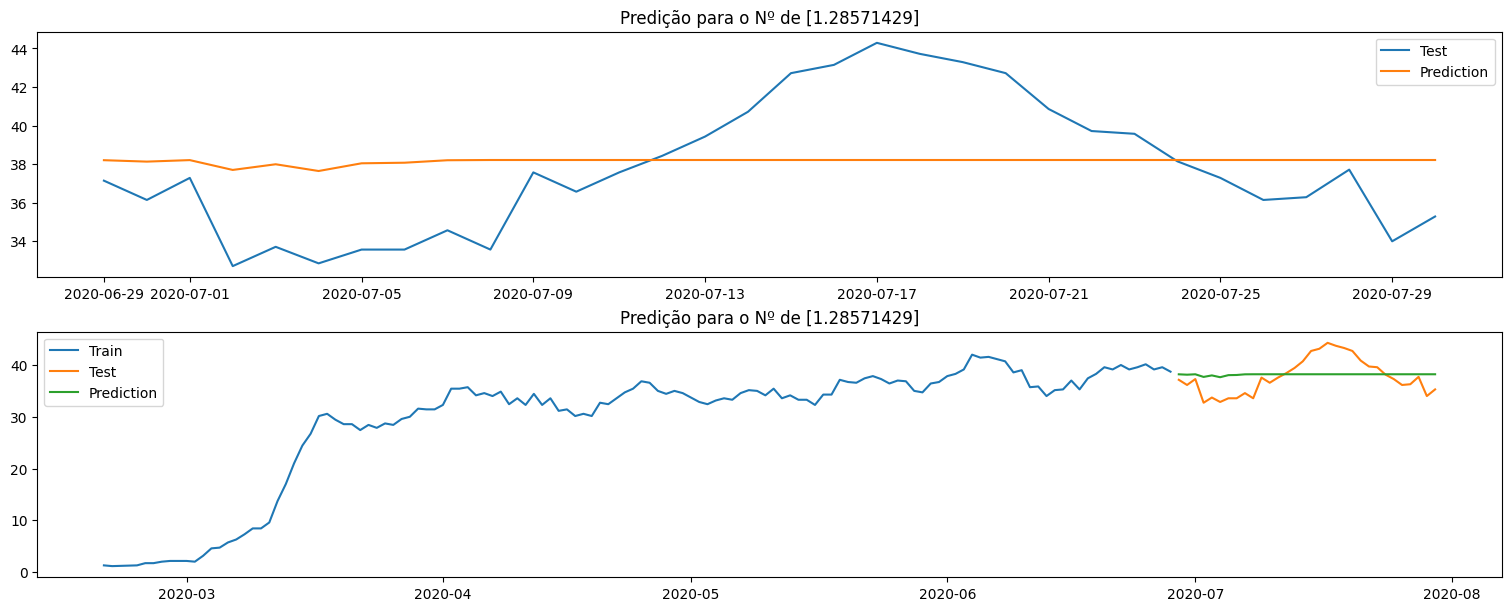


Gostaria de realizar novas previsões?
Não : 0
Sim : 1

PROGRAMA FINALIZADO!



In [109]:
create_sentiment_forecast(df_sentimento)

### Chile


    Deseja criar a previsão de sentimentos negativos para qual pais?

    Argentina  : 0
    Chile      : 1
    Ecuador    : 2
    Espanha    : 3
    Mexico     : 4
    
Previsão em andamento...
Previsão para "chile" realizada com sucesso!

R²   ---  -0.04
MAE  ---  1.60
RMSE ---  2.11
MAPE ---  0.04250073660349189


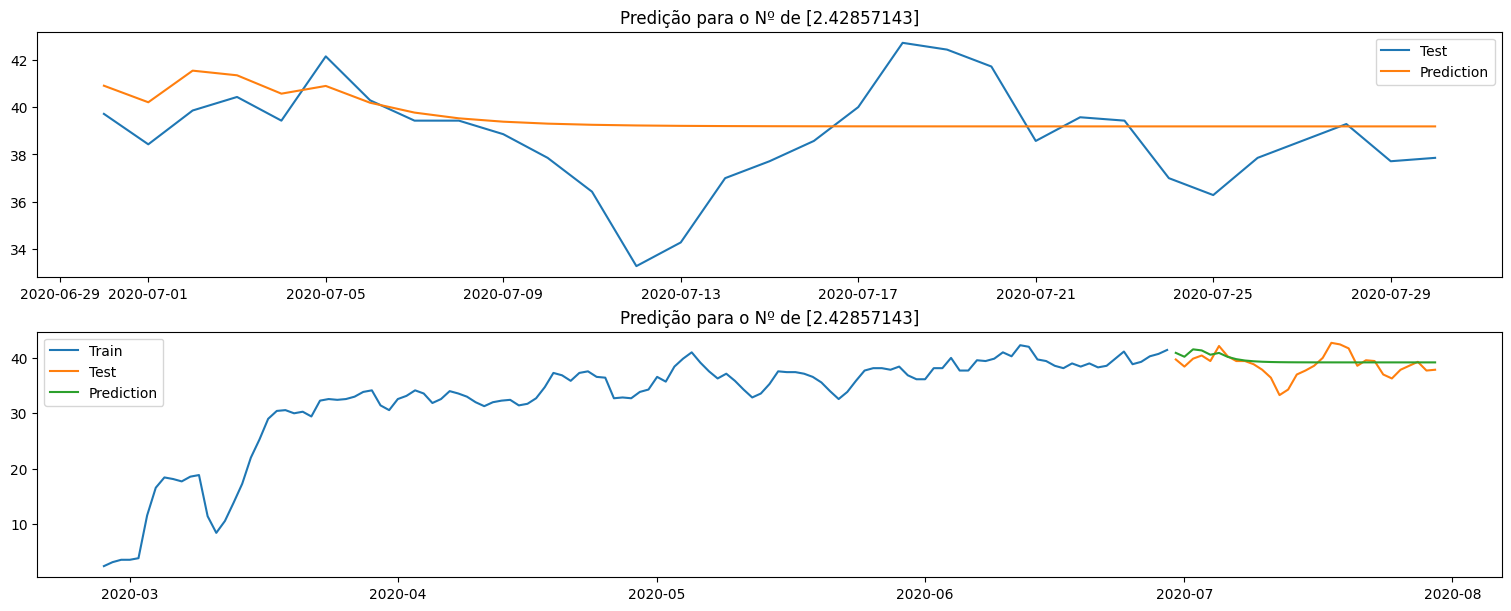


Gostaria de realizar novas previsões?
Não : 0
Sim : 1

PROGRAMA FINALIZADO!



In [103]:
create_sentiment_forecast(df_sentimento)

### Equador


    Deseja criar a previsão de sentimentos negativos para qual pais?

    Argentina  : 0
    Chile      : 1
    Ecuador    : 2
    Espanha    : 3
    Mexico     : 4
    
Previsão em andamento...
Previsão para "equador" realizada com sucesso!

R²   ---  -0.44
MAE  ---  2.65
RMSE ---  3.21
MAPE ---  0.07907759870017919


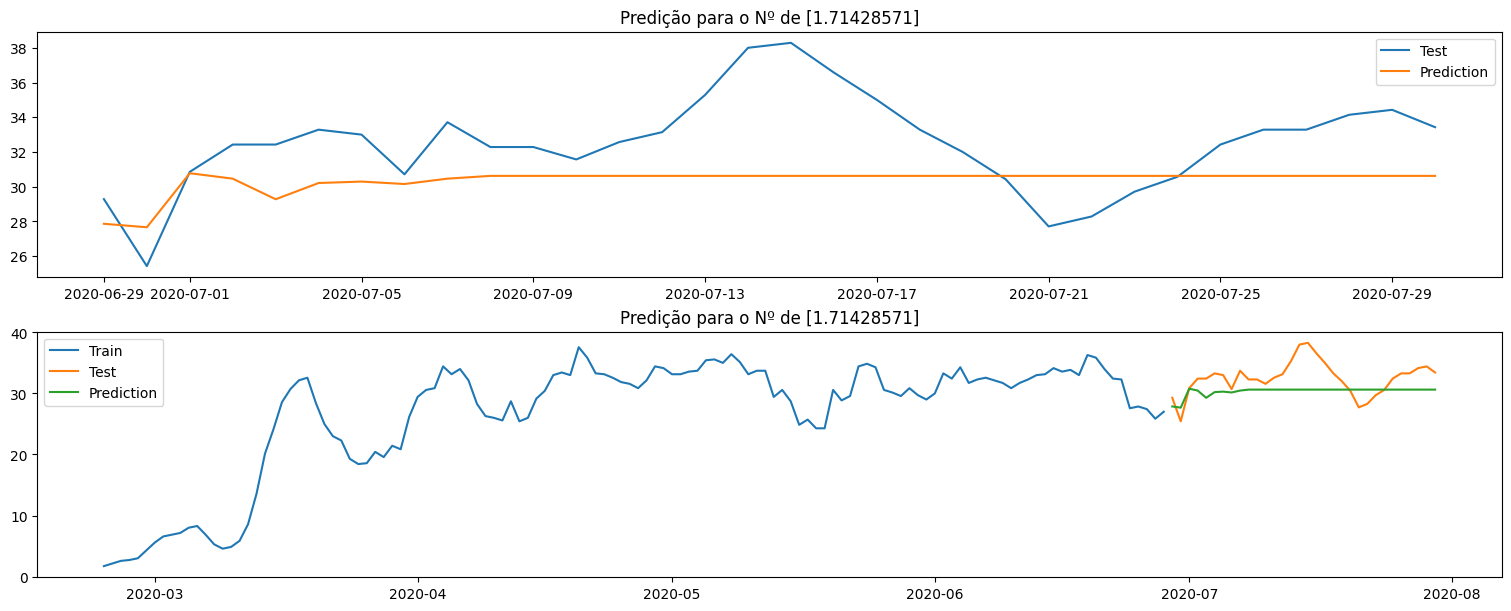


Gostaria de realizar novas previsões?
Não : 0
Sim : 1

PROGRAMA FINALIZADO!



In [104]:
create_sentiment_forecast(df_sentimento)

### Espanha


    Deseja criar a previsão de sentimentos negativos para qual pais?

    Argentina  : 0
    Chile      : 1
    Ecuador    : 2
    Espanha    : 3
    Mexico     : 4
    
Previsão em andamento...
Previsão para "espanha" realizada com sucesso!

R²   ---  -1.19
MAE  ---  6.00
RMSE ---  7.66
MAPE ---  0.10725350161693337


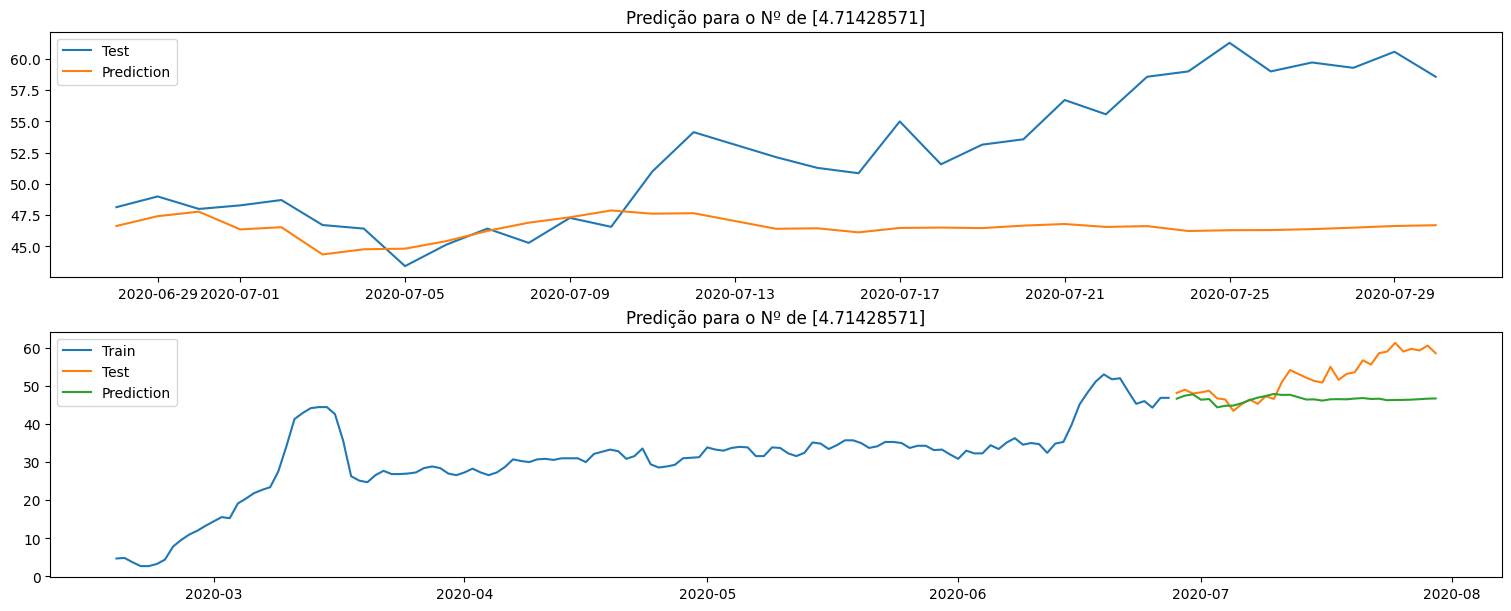


Gostaria de realizar novas previsões?
Não : 0
Sim : 1

PROGRAMA FINALIZADO!



In [105]:
create_sentiment_forecast(df_sentimento)

### Mexico


    Deseja criar a previsão de sentimentos negativos para qual pais?

    Argentina  : 0
    Chile      : 1
    Ecuador    : 2
    Espanha    : 3
    Mexico     : 4
    
Previsão em andamento...
Previsão para "mexico" realizada com sucesso!

R²   ---  -1.34
MAE  ---  1.86
RMSE ---  2.36
MAPE ---  0.04936144942944188


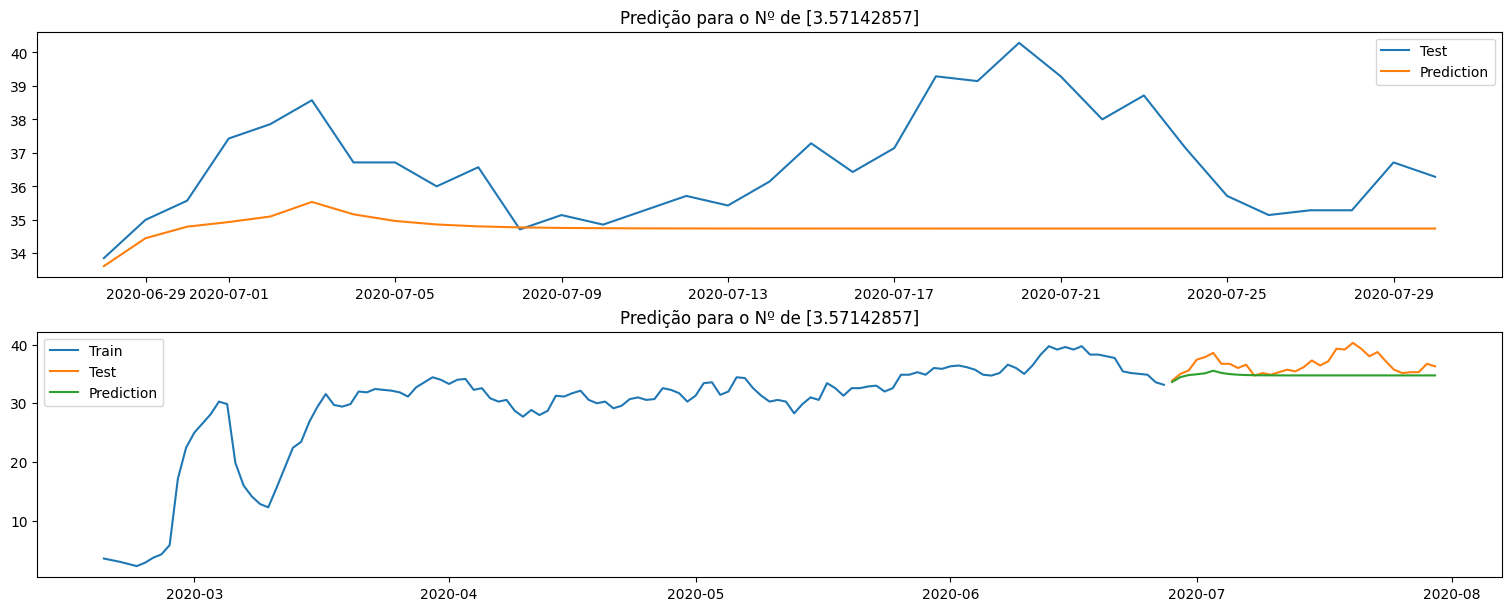


Gostaria de realizar novas previsões?
Não : 0
Sim : 1

PROGRAMA FINALIZADO!



In [106]:
create_sentiment_forecast(df_sentimento) 